## RandomForest Classifier improved on larger dataset

В данной версии используется **сбалансированный датасет на 56 000 записей** (по 14 000 на каждый класс: match, weak_match, related, no_match). По сравнению с ранними экспериментами датасет был максимально размечен, а набор признаков существенно расширен.

**Признаки (7 шт):**

1. **Multilingual cosine similarity** — текстовые поля RFQ и Supplier кодируются через модель **paraphrase-multilingual-MiniLM-L12-v2** (50+ языков), после чего вычисляются cosine similarity между парами: `rfq<=>supplier` и `rfq<=>products+keywords`.

2. **Поэлементное сравнение supplier types** — `rfq_supplier_types` и `supplier_types` сравниваются item-by-item через multilingual модель; извлекаются avg и max лучших совпадений.

3. **Анализ зон доставки / локаций (`country_match_signal`)** — на основе `distribution_area` поставщика и справочника стран определяется степень географического совпадения с `delivery_location` RFQ (0 / 1 / 2).

4. **Категориальный признак (`category_match`, `category_best_sim`)** — `category_id` RFQ сопоставляется с `product_categories` supplier через семантический маппинг: multilingual-названия product_categories сопоставляются с категориями из немецкого справочника `categories.csv`, после чего проверяется совпадение и вычисляется cosine similarity.

**Классификатор:** RandomForestClassifier с `class_weight='balanced'`.  
**Задача:** классификация типа совпадения RFQ–Supplier (match, weak_match, related, no_match).

---
## 1. Импорты и настройки


In [24]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

---
## 2. Загрузка данных

In [38]:
data_path = Path("dataset/result_dataset_balanced_56k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)
print("\nРаспределение классов:")
print(df["match_type"].value_counts())

Форма датасета: (56000, 16)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'category_id', 'rfq_supplier_types',
       'supplier_name', 'supplier_country', 'distribution_area',
       'supplier_description', 'supplier_types', 'products',
       'product_categories', 'keywords', 'match_type'],
      dtype='object')

Распределение классов:
match_type
match         14000
no_match      14000
related       14000
weak_match    14000
Name: count, dtype: int64


---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), подсчёт пропусков, заполнение пропусков в текстовых полях, формирование текстовых признаков для получения эмбеддингов.

**Важно**: поля `rfq_supplier_types` и `supplier_types` исключены из основных текстовых признаков — они сравниваются **поэлементно** через multilingual модель. Каждый тип из rfq сравнивается с каждым типом supplier, например:

покупатель хочет {MANUFACTURER, Wholesaler}, а поставщик предлагает {Production, Wholesaler} => 
MANUFACTURER-Production (high sim), MANUFACTURER-Wholesaler (low sim), Wholesaler-Production (low sim), Wholesaler-Wholesaler (very high sim).  
Из этой матрицы извлекаются `cos_supplier_types_avg` (среднее лучших совпадений) и `cos_supplier_types_max` (лучшая пара).

In [39]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)

df.head()

,rfq_id,rfq_title,rfq_description,quantity,delivery_location,category_id,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type
0,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER","WHY NOT?, LDA.",PT,international,The journey of Why Not? Bags began with the cr...,"Production, CustomerSpecificManufacturing","In-House Collection of Ready-to-Use Models, In...",Clothing and accessories,"Clothes and fashion model collections, High fa...",match
1,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",NY CORK,TR,international,The Nine Years is a premium Istanbul-based bra...,Production,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W...",Design,"cork bags, cork handbags, cork accessories, wo...",match
2,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER","FARL CORK UNIPESSOAL, LDA",PT,international,FARL CORK is a company established in late 201...,Production,"Natural yoga block, Fine grain cork block - Yo...",Wood and wood products,"Cortiça - produtos, yoga, cortiça granulada, R...",match
3,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",EMPREMTA BARCELONA,ES,europe,"At Empremta Barcelona, we specialize in the sa...","CustomerSpecificManufacturing, Wholesaler, Ser...",Customizable polyester drawstring backpack 190...,"""Marketing, advertising and sales""","Lightweight backpack, durable backpack, daily ...",match
4,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",KORK-STUDIO GROBE BRIGITTE GROBE,DE,europe,Everything made of cork has been our motto for...,Wholesaler,"Cork Dartboard, Cork box - Ø 90 x 60 mm, ""Cork...",Wood and wood products,"Sportartikel, Dartboards, Dartscheiben, Aufbew...",match


In [40]:
nan_counts = df.isna().sum()
has_nans = nan_counts.sum() > 0
if has_nans:
    print("Пропуски по колонкам (до заполнения):")
    for col in df.columns:
        if nan_counts[col] > 0:
            print(f"  {col}: {nan_counts[col]}")
else:
    print("Пропусков нет.")

Пропуски по колонкам (до заполнения):
  quantity: 1
  category_id: 50
  distribution_area: 11080
  supplier_description: 3054


In [41]:
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

---
## 3.0.1. Географический признак: country_match_signal

Используем `distribution_area` поставщика и справочник `distribution_areas_country_codes.csv` для создания признака совпадения стран.

Правила:
1. Если `distribution_area` пустая — используем `supplier_country` как единственную страну доставки
2. Если `supplier_country == delivery_location` — **strong signal** (значение 2)
3. Если `delivery_location` входит в множество стран `distribution_area` — **medium signal** (значение 1)
4. Иначе — 0

In [51]:
dist_areas_df = pd.read_csv("dataset/distribution_areas_country_codes.csv")

dist_area_map = {}
for _, row in dist_areas_df.iterrows():
    area = row["distribution_area"]
    countries_str = str(row["delivery_locations"]).strip("{}")
    dist_area_map[area] = set(countries_str.split(","))

print("Distribution area => number of countries:")
for area, countries in dist_area_map.items():
    print(f"  {area}: {len(countries)} countries")


def compute_country_signal(row):
    delivery_loc = str(row["delivery_location"]).strip()
    supplier_country = str(row["supplier_country"]).strip()
    distribution_area = str(row["distribution_area"]).strip()

    if supplier_country and delivery_loc and supplier_country == delivery_loc:
        return 2

    if distribution_area and distribution_area in dist_area_map:
        effective_countries = dist_area_map[distribution_area]
    else:
        effective_countries = {supplier_country} if supplier_country else set()

    if delivery_loc in effective_countries:
        return 1

    return 0


df["country_match_signal"] = df.apply(compute_country_signal, axis=1)

print(f"\ncountry_match_signal distribution:")
print(df["country_match_signal"].value_counts().sort_index())
print(f"\ncountry_match_signal by match_type:")
print(df.groupby("match_type")["country_match_signal"].mean())

Distribution area => number of countries:
  europe: 149 countries
  international: 155 countries
  national: 134 countries
  regional: 109 countries

country_match_signal distribution:
country_match_signal
0    10313
1    36011
2     9676
Name: count, dtype: int64

country_match_signal by match_type:
match_type
match         1.001143
no_match      1.026214
related       0.953357
weak_match    0.973786
Name: country_match_signal, dtype: float64


In [43]:
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str)
)

df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["supplier_country"].astype(str)
)

df["multilingual_text"] = (
    df["products"].astype(str) + " "
    + df["keywords"].astype(str)
)

df[["rfq_text", "supplier_text", "multilingual_text"]].head(10)

,rfq_text,supplier_text,multilingual_text
0,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","WHY NOT?, LDA. The journey of Why Not? Bags be...","In-House Collection of Ready-to-Use Models, In..."
1,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK The Nine Years is a premium Istanbul-b...,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W..."
2,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","FARL CORK UNIPESSOAL, LDA FARL CORK is a compa...","Natural yoga block, Fine grain cork block - Yo..."
3,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","EMPREMTA BARCELONA At Empremta Barcelona, we s...",Customizable polyester drawstring backpack 190...
4,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORK-STUDIO GROBE BRIGITTE GROBE Everything ma...,"Cork Dartboard, Cork box - Ø 90 x 60 mm, ""Cork..."
5,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL DERI ITHALAT IHRACAT SAN VE TI...,"""CORK GIFTS PRODUCTS, HOME AND HOTEL DECORATI..."
6,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",AMADIACORK DESIGNED BY NATURE Welcome to Amad...,"Cork fabric - Colorful cork fabrics, Cork Fabr..."
7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",MONARCH CORK & TEXTILE Monarch Textile & Bag '...,"Smyrna Cork Handbag - SKU: MC-A25N, Smyrna Cor..."
8,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL ITH IHR SAN VE TIC AS NY-Cork ...,"Cork Shoulder Bag with Eco-Friendly Material, ..."
9,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORKALLEE.DE - ECO-FASHION AUS KORK KorkAllee....,


---
## 3.1. Cosine Similarity на основе Multilingual Embeddings

Используем модель **paraphrase-multilingual-MiniLM-L12-v2** (384 dim, 50+ языков) для кодирования текстовых полей.

**Важно**: `product_categories` исключён из `multilingual_text` — теперь это отдельный категориальный признак (см. 3.2).

Признаки из этого блока:
1. **cos_rfq_supplier** — `rfq_text` <=> `supplier_text`
2. **cos_rfq_multilingual** — `rfq_text` <=> `multilingual_text` (products + keywords, без product_categories)
3. **cos_supplier_types_avg** — среднее лучшее поэлементное совпадение типов
4. **cos_supplier_types_max** — максимальное поэлементное совпадение типов

In [44]:
ml_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

print("Кодируем rfq_text...")
rfq_embeddings = ml_model.encode(
    df["rfq_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем supplier_text...")
supplier_embeddings = ml_model.encode(
    df["supplier_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем multilingual_text (products + categories + keywords)...")
multilingual_embeddings = ml_model.encode(
    df["multilingual_text"].tolist(), show_progress_bar=True, batch_size=64
)

df["cos_rfq_supplier"] = [
    sklearn_cosine_similarity(r.reshape(1, -1), s.reshape(1, -1))[0, 0]
    for r, s in zip(rfq_embeddings, supplier_embeddings)
]
df["cos_rfq_multilingual"] = [
    sklearn_cosine_similarity(r.reshape(1, -1), m.reshape(1, -1))[0, 0]
    for r, m in zip(rfq_embeddings, multilingual_embeddings)
]

print("Кодируем supplier types поэлементно...")
all_type_items = set()
for col in ["rfq_supplier_types", "supplier_types"]:
    for val in df[col]:
        for item in str(val).split(", "):
            item = item.strip()
            if item:
                all_type_items.add(item)

all_type_items = sorted(all_type_items)
print(f"  Уникальных типов: {len(all_type_items)}")

type_embeddings_arr = ml_model.encode(all_type_items, show_progress_bar=True, batch_size=64)
type_emb_map = {item: emb for item, emb in zip(all_type_items, type_embeddings_arr)}


def compute_itemwise_type_similarity(rfq_types_str, sup_types_str):
    rfq_items = [t.strip() for t in str(rfq_types_str).split(", ") if t.strip()]
    sup_items = [t.strip() for t in str(sup_types_str).split(", ") if t.strip()]

    if not rfq_items or not sup_items:
        return 0.0, 0.0

    rfq_embs = np.array([type_emb_map[t] for t in rfq_items if t in type_emb_map])
    sup_embs = np.array([type_emb_map[t] for t in sup_items if t in type_emb_map])

    if rfq_embs.size == 0 or sup_embs.size == 0:
        return 0.0, 0.0

    sim_matrix = sklearn_cosine_similarity(rfq_embs, sup_embs)

    avg_best = np.mean(np.max(sim_matrix, axis=1))
    best_match = np.max(sim_matrix)
    return float(avg_best), float(best_match)


type_sims = df.apply(
    lambda row: compute_itemwise_type_similarity(row["rfq_supplier_types"], row["supplier_types"]),
    axis=1,
)
df["cos_supplier_types_avg"] = type_sims.apply(lambda x: x[0])
df["cos_supplier_types_max"] = type_sims.apply(lambda x: x[1])

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1630.08it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Кодируем rfq_text...


Batches: 100%|██████████| 875/875 [01:20<00:00, 10.84it/s]


Кодируем supplier_text...


Batches: 100%|██████████| 875/875 [01:32<00:00,  9.49it/s]


Кодируем multilingual_text (products + categories + keywords)...


Batches: 100%|██████████| 875/875 [01:55<00:00,  7.57it/s]


Кодируем supplier types поэлементно...
  Уникальных типов: 15


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


---
## 3.2. Категориальный признак: category_match

RFQ содержит `category_id` — ID категории из справочника `categories.csv` (немецкие названия).  
Supplier содержит `product_categories` — массив строк на **любом языке** (DE, EN, и др.).

Подход:
1. Кодируем все 112 категорий из справочника через multilingual модель
2. Кодируем все уникальные `product_categories` из датасета
3. Для каждого product_category находим ближайшую категорию из справочника по cosine similarity => получаем `resolved_category_id`
4. Для каждой строки проверяем: входит ли `category_id` RFQ в множество `resolved_category_id` supplier'а
5. Итого 2 признака:
   - **category_match** (0/1) — бинарное совпадение категории
   - **category_best_sim** — cosine similarity между категорией RFQ и ближайшей product_category supplier'а

In [52]:
categories_df = pd.read_csv("dataset/categories.csv")
cat_id_to_name = dict(zip(categories_df["category_id"], categories_df["category_name"]))
cat_names = categories_df["category_name"].tolist()
cat_ids = categories_df["category_id"].tolist()

print(f"Категорий в справочнике: {len(cat_names)}")
print("Кодируем категории справочника...")
cat_embeddings = ml_model.encode(cat_names, show_progress_bar=True, batch_size=64)

all_prod_cats = set()
for val in df["product_categories"]:
    for item in str(val).split(", "):
        item = item.strip()
        if item:
            all_prod_cats.add(item)

all_prod_cats = sorted(all_prod_cats)
print(f"Уникальных product_categories в датасете: {len(all_prod_cats)}")
print("Кодируем product_categories...")
prod_cat_embeddings = ml_model.encode(all_prod_cats, show_progress_bar=True, batch_size=64)

sim_matrix = sklearn_cosine_similarity(prod_cat_embeddings, cat_embeddings)

prod_cat_emb_map = {pc: emb for pc, emb in zip(all_prod_cats, prod_cat_embeddings)}

prod_cat_to_resolved = {}
for i, pc in enumerate(all_prod_cats):
    best_idx = int(np.argmax(sim_matrix[i]))
    best_sim = float(sim_matrix[i, best_idx])
    prod_cat_to_resolved[pc] = (cat_ids[best_idx], best_sim)

print("\nПримеры маппинга product_category => category (top similarity):")
samples = list(prod_cat_to_resolved.items())[:10]
for pc, (cid, sim) in samples:
    print(f"  '{pc}' => {cid} ('{cat_id_to_name[cid]}') sim={sim:.3f}")

cat_name_emb_map = {cid: emb for cid, emb in zip(cat_ids, cat_embeddings)}


def compute_category_features(row):
    rfq_cat_id = row["category_id"]
    prod_cats_str = str(row["product_categories"]).strip()

    if pd.isna(rfq_cat_id) or rfq_cat_id == "":
        return 0, 0.0

    rfq_cat_id = int(rfq_cat_id)
    if rfq_cat_id not in cat_name_emb_map:
        return 0, 0.0

    sup_items = [t.strip() for t in prod_cats_str.split(", ") if t.strip()]
    if not sup_items:
        return 0, 0.0

    rfq_emb = cat_name_emb_map[rfq_cat_id].reshape(1, -1)
    sup_embs = []
    resolved_ids = []
    for item in sup_items:
        if item in prod_cat_to_resolved:
            resolved_ids.append(prod_cat_to_resolved[item][0])
            sup_embs.append(prod_cat_emb_map[item])

    if not sup_embs:
        return 0, 0.0

    sup_embs_arr = np.array(sup_embs)
    sims = sklearn_cosine_similarity(rfq_emb, sup_embs_arr)[0]
    best_sim = float(np.max(sims))

    match = 1 if rfq_cat_id in resolved_ids else 0
    return match, best_sim


print("\nВычисляем category_match и category_best_sim...")
cat_features = df.apply(compute_category_features, axis=1)
df["category_match"] = cat_features.apply(lambda x: x[0])
df["category_best_sim"] = cat_features.apply(lambda x: x[1])

feature_cols = [
    "cos_rfq_supplier", "cos_rfq_multilingual",
    "cos_supplier_types_avg", "cos_supplier_types_max",
    "country_match_signal",
    "category_match", "category_best_sim",
]

print(f"\nМодель: paraphrase-multilingual-MiniLM-L12-v2")
print(f"Признаки: {len(feature_cols)}")
print(f"\nСтатистика признаков:")
print(df[feature_cols].describe())
print(f"\ncategory_match by match_type:")
print(df.groupby("match_type")[["category_match", "category_best_sim"]].mean())

Категорий в справочнике: 112
Кодируем категории справочника...


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Уникальных product_categories в датасете: 257
Кодируем product_categories...


Batches: 100%|██████████| 5/5 [00:00<00:00, 66.24it/s]



Примеры маппинга product_category => category (top similarity):
  '"Bedarf für Landwirtschaft' => 100039 ('Erzeugnisse aus Landwirtschaft, Forstwirtschaft, Fischerei, Gartenbau') sim=0.749
  '"Befestigungstechnik' => 100031 ('Befestigungstechnik, Verbindungstechnik & Beschläge') sim=0.873
  '"Behälter' => 100015 ('Fügen') sim=0.683
  '"Casting' => 100036 ('Dichtungstechnik') sim=0.516
  '"Containers' => 100036 ('Dichtungstechnik') sim=0.764
  '"Dienstleistungen aus Landwirtschaft' => 100040 ('Dienstleistungen aus Landwirtschaft, Forstwirtschaft, Fischerei, Gartenbau') sim=0.854
  '"Erzeugnisse aus Landwirtschaft' => 100039 ('Erzeugnisse aus Landwirtschaft, Forstwirtschaft, Fischerei, Gartenbau') sim=0.808
  '"Fastening technology' => 100078 ('Sanitärtechnik') sim=0.784
  '"Foto-' => 100094 ('Foto-, Film- & Tondienstleistungen') sim=0.761
  '"Freizeit' => 100015 ('Fügen') sim=0.863

Вычисляем category_match и category_best_sim...

Модель: paraphrase-multilingual-MiniLM-L12-v2
Признаки:

---
## 4. Разбиение на обучающую и тестовую выборки (80 / 20)

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку, чтобы избежать data leakage. Модель (RandomForest) и гиперпараметры были выбраны в предыдущих версиях, поэтому валидационная выборка не нужна.

In [46]:
y = df["match_type"]
groups = df["rfq_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, y, groups))

X_train = df.loc[train_idx, feature_cols]
y_train = y.iloc[train_idx]
X_test = df.loc[test_idx, feature_cols]
y_test = y.iloc[test_idx]

print(f"Размер обучающей выборки (train): {len(X_train)}")
print(f"Размер тестовой выборки (test): {len(X_test)}")
print(f"Количество признаков: {X_train.shape[1]}")

print(f"\nРаспределение классов (train):\n{y_train.value_counts()}")
print(f"\nРаспределение классов (test):\n{y_test.value_counts()}")

Размер обучающей выборки (train): 44735
Размер тестовой выборки (test): 11265
Количество признаков: 7

Распределение классов (train):
match_type
related       11223
no_match      11216
match         11211
weak_match    11085
Name: count, dtype: int64

Распределение классов (test):
match_type
weak_match    2915
match         2789
no_match      2784
related       2777
Name: count, dtype: int64


---
## 5. Модель и обучение

Признаки (7 dim):
1. `cos_rfq_supplier` — rfq <=> supplier (cosine similarity)
2. `cos_rfq_multilingual` — rfq <=> multilingual / products + keywords (cosine similarity)
3. `cos_supplier_types_avg` — среднее лучшее поэлементное совпадение типов
4. `cos_supplier_types_max` — максимальное поэлементное совпадение типов
5. `country_match_signal` — географическое совпадение (0 / 1 / 2)
6. `category_match` — совпадение category_id RFQ с resolved product_categories supplier (0/1)
7. `category_best_sim` — cosine similarity между категорией RFQ и ближайшей product_category

Классификатор: **RandomForestClassifier** с `class_weight='balanced'`.

In [47]:
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

---
## 6. Оценка качества и визуализация

In [48]:
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Test — classification report:
              precision    recall  f1-score   support

       match       0.28      0.25      0.26      2789
    no_match       0.37      0.42      0.39      2784
     related       0.29      0.30      0.29      2777
  weak_match       0.29      0.28      0.28      2915

    accuracy                           0.31     11265
   macro avg       0.31      0.31      0.31     11265
weighted avg       0.31      0.31      0.31     11265

Test — accuracy: 0.3096

Confusion matrix (test):
[[ 689  655  669  776]
 [ 472 1162  583  567]
 [ 617  654  821  685]
 [ 688  679  732  816]]


In [49]:
importances = clf.feature_importances_

print("Важность признаков:")
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"  {name}: {imp:.4f}")

Важность признаков:
  cos_rfq_multilingual: 0.2920
  cos_rfq_supplier: 0.2910
  category_best_sim: 0.2238
  cos_supplier_types_avg: 0.0880
  cos_supplier_types_max: 0.0696
  country_match_signal: 0.0284
  category_match: 0.0071


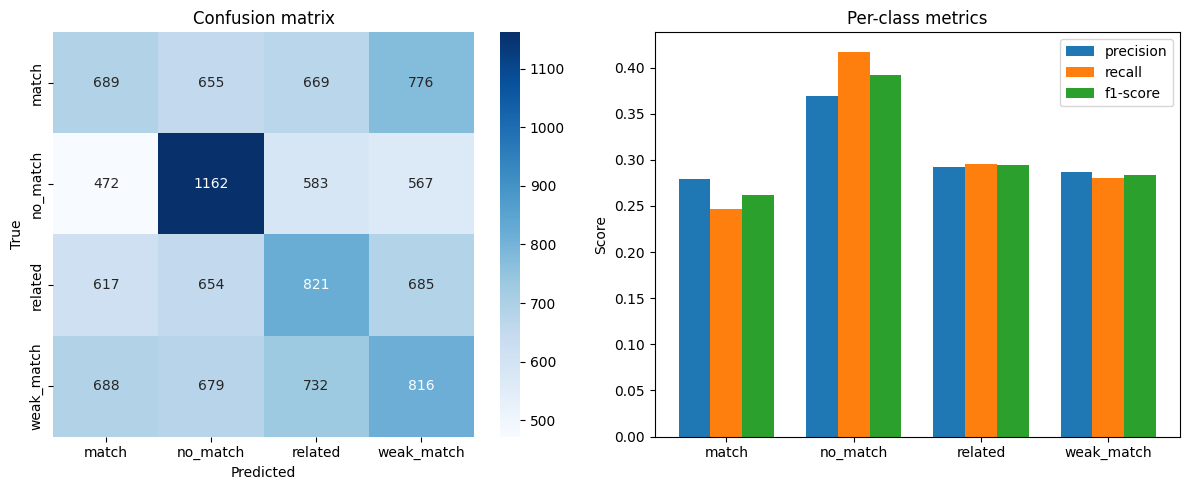

In [50]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Выводы

### Данные и признаки

Использован **сбалансированный датасет на 56 000 записей** (по 14 000 на каждый класс). Датасет был максимально размечен — для каждого RFQ подобраны примеры всех четырёх классов совпадений (match, weak_match, related, no_match).

В данной версии набор признаков был существенно расширен:

| Признак | Описание | Важность (RF) |
|---|---|---|
| `cos_rfq_multilingual` | Cosine similarity: rfq <=> products + keywords | 0.2920 |
| `cos_rfq_supplier` | Cosine similarity: rfq <=> supplier description | 0.2910 |
| `category_best_sim` | Cosine similarity между категорией RFQ и ближайшей product_category supplier | 0.2238 |
| `cos_supplier_types_avg` | Среднее лучшее поэлементное совпадение типов | 0.0880 |
| `cos_supplier_types_max` | Максимальное поэлементное совпадение типов | 0.0696 |
| `country_match_signal` | Географическое совпадение (distribution_area / delivery_location) | 0.0284 |
| `category_match` | Бинарное совпадение category_id RFQ с resolved product_categories | 0.0071 |

Были добавлены **категориальные признаки** (`category_match`, `category_best_sim`) — сопоставление категории RFQ с product_categories supplier через семантический маппинг multilingual-модели, а также **анализ зон доставки и локаций** (`country_match_signal`) — проверка, попадает ли delivery_location RFQ в зону distribution_area поставщика.

### Результаты

- **Test accuracy:** 0.31 (при случайном угадывании на 4 классах — 0.25)
- **Test macro-F1:** 0.31
- Модель предсказывает **все 4 класса**, распределение ошибок относительно равномерное
- Лучше всего выделяется класс `no_match` (F1 = 0.39), хуже всего — `match` (F1 = 0.26)

### Анализ важности признаков

Три признака делят между собой почти всё информационное содержание:
- **Cosine similarity rfq<=>multilingual и rfq<=>supplier** — по ~29% каждый — основные текстовые сигналы
- **category_best_sim** — ~22% — категориальный признак оказался третьим по важности, подтверждая ценность семантического маппинга категорий через multilingual модель

Остальные признаки (supplier types, geography, binary category match) вносят меньший, но ненулевой вклад.

### Пределы RandomForest на данной задаче

Accuracy ~0.31 и macro-F1 ~0.31 на 4-классовой задаче — это лучше случайного угадывания, но далеко от практической полезности. Были использованы все доступные структурированные признаки: текстовая семантика (multilingual embeddings + cosine similarity), категории (semantic mapping через справочник), типы поставщиков (поэлементное сравнение), география (distribution_area + delivery_location). Это, по всей видимости, **максимум, который можно получить от RandomForest Classifier** на данных признаках.

Основная причина — RandomForest работает с 7 скалярными признаками (cosine similarity и сигналы), теряя при этом большую часть информации из исходных 384-мерных эмбеддингов. Для дальнейшего улучшения качества необходим переход к моделям, способным работать с полными эмбеддингами напрямую